# Predicting Air Pollutant Levels with Weather and Air Quality Data
In this notebook I:
- Load and clean 4 years worth (2016-2019) of daily  meteorological  and air quality ($NO_2, CO$ and $PM2.5$ concentrations ) data in approximately 150 locations around California. 
- Analyze the time variation of the air quality measurement data. 
- Identify the closest locations of weather and air pollutant levels to locations of the pollutant whose concentration we want to predict (in this notebook I chose $NO_2$) and join data sets accordingly. 
-Calculate the relative uncertainty of pollutant measurements based on distance. This is done to determine a distance cutoff beyond which data is not utilized if the distance between the air pollutants and weather measurements and the prediction pollutant ($NO_2$) exceeds the cutoff uncertainty. 
- Exploratory analysis: I calculate the correlation matrices for the air quality and weather data to gain some understanding about which features will be most predictive. 
- Train and test a set of models to predict concentrations of $NO_2$. I explore a number of models and cross validation methods:
   - Models: I compare the performance of Linear, Polynomial and Random Forest regression models. 
   - Cross-Validation: I test and discuss effectiveness of K-fold cross validation and Group K-fold cross validation methods. 
   - Train and cross-validate models by reducing number of features and changing hyper-parameters to optimize predictions. 
   - Compare performance of RF model with reduced features.  
   - Finally I retrain the optimized model (RF) and find its error metrics with test data. 







In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
import seaborn as sns
from matplotlib.colors import LogNorm


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

from sklearn import metrics

## Import data

The air pollutant data was sourced from: https://www.epa.gov/outdoor-air-quality-data/download-daily-data. 

I used the WorldWeatherOnline historical weather data API wrapper (https://github.com/ekapope/WorldWeatherOnline) to retrieve historical weather data at chosen locations in California from  www.worldweatheronline.com. The weather data locations were chosen to match as near as possible to all the locations of the air pollutant data.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/open?id=103R7n_Abr8h6pIruWXR4K1bDApPkNelZ'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('CO_data.csv')  
CO_data = pd.read_csv('CO_data.csv')

103R7n_Abr8h6pIruWXR4K1bDApPkNelZ


In [4]:
link = 'https://drive.google.com/open?id=10BHXjj99Od_2k6u7Sn5PsD_YHyAlARzH'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NO2_data.csv')  
NO2_data = pd.read_csv('NO2_data.csv')

10BHXjj99Od_2k6u7Sn5PsD_YHyAlARzH


In [5]:
link = 'https://drive.google.com/open?id=10BzWNPiMjkYGyqST-_zD_JVAzFKV6kNu'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('PM25_data.csv')  
PM25_data = pd.read_csv('PM25_data.csv')

10BzWNPiMjkYGyqST-_zD_JVAzFKV6kNu


In [6]:
link = 'https://drive.google.com/open?id=1Nl0eA85q4WAvIDfL6s807VpA3rJw3LGA'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ces3results.xlsx') 
census_data = pd.read_excel(r'ces3results.xlsx')

1Nl0eA85q4WAvIDfL6s807VpA3rJw3LGA


In [7]:
link = 'https://drive.google.com/open?id=1EhlmA1VvzN-rG2j7d332j4RY_rgngk4B'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('weather_data3tot.csv')  
weather_data1 = pd.read_csv('weather_data3tot.csv')

1EhlmA1VvzN-rG2j7d332j4RY_rgngk4B


In [8]:
link = 'https://drive.google.com/open?id=1WyYLg7oDPpotdTciI4mqiqkjlpIR9ZU0'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('weather_data4tot.csv')  
weather_data2 = pd.read_csv('weather_data4tot.csv')

1WyYLg7oDPpotdTciI4mqiqkjlpIR9ZU0


In [9]:
link = 'https://drive.google.com/open?id=10DjJAX6MoZo0yy7owyOYpOs3yWGWqcq3'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('latitude_longitude_locations.npy')  
locations = np.load('latitude_longitude_locations.npy')

10DjJAX6MoZo0yy7owyOYpOs3yWGWqcq3


In [0]:
weather_data = pd.concat([weather_data1, weather_data2])

## Data cleaning and processing



Making separate columns in data frame for the latitude and longitude of the weather data.





In [0]:
a = weather_data['location'].str.split(",", expand = True).astype(float) 
weather_data['latitude'] = a[0]
weather_data['longitude'] = a[1]


Reformatting date-time columns for air pollutant and weather data so that the format matches (i.e. Y-m-d).




In [0]:
date_local1 = CO_data['Date'] 
c1 = date_local1.str.split("/", expand = True) 
c1['date'] = c1[[2,0,1]].apply(lambda x: '-'.join(x), axis = 1) 
date_time1 = pd.to_datetime(c1['date'] , format='%Y-%m-%d' )
CO_data['date_time'] = date_time1

date_local2 = NO2_data['Date'] 
c2 = date_local2.str.split("/", expand = True) 
c2['date'] = c2[[2,0,1]].apply(lambda x: '-'.join(x), axis = 1) 
date_time2 = pd.to_datetime(c2['date'] , format='%Y-%m-%d' )
NO2_data['date_time'] = date_time2

date_local3 = PM25_data['Date'] 
c3 = date_local3.str.split("/", expand = True) 
c3['date'] = c3[[2,0,1]].apply(lambda x: '-'.join(x), axis = 1) 
date_time3 = pd.to_datetime(c3['date'] , format='%Y-%m-%d' )
PM25_data['date_time'] = date_time3

In [0]:
c4 = weather_data['date_time'].astype(str)
date_time4 = pd.to_datetime(c4 , format='%Y-%m-%d' )
weather_data['date_time'] = date_time4

### Time and space indicators 

The weather data latitudes and longitudes are only up to 3 significant figures (3 decimal places) so to match the air quality data I round up to 3 sig. figs. for their locations as well. 

In [0]:
def add_floor(data):
  data['latitude'] = (np.floor(data['SITE_LATITUDE']*1000))#*0.001 #.apply(np.floor))*0.001
  data['latitude'] = data['latitude'].divide(1000)
  data['longitude'] = (np.floor(data['SITE_LONGITUDE']*1000)) #*0.001 #.apply(np.floor))
  data['longitude'] =data['longitude'].divide(1000)
  return data

In [0]:
CO_dataf = add_floor(CO_data)
NO2_dataf = add_floor(NO2_data)
PM25_dataf = add_floor(PM25_data)

To match the different data frames based on time and location it is useful to set their indices to be a MultiIndex with the latitude, longitude and date. 

In [0]:
df_index = weather_data.loc[:,['date_time','latitude', 'longitude']]
weather_index = pd.MultiIndex.from_frame(df_index, names=['date', 'lat', 'long'])
weather_datai= weather_data.set_index(weather_index)

df_index2 = weather_data.loc[:,['latitude', 'longitude']]
weather_index2 = pd.MultiIndex.from_frame(df_index2, names=['lat', 'long'])
weather_datai2= weather_data.set_index(weather_index2)

In [0]:
df_indexCO = CO_dataf.loc[:,['date_time', 'latitude', 'longitude']]
CO_index = pd.MultiIndex.from_frame(df_indexCO, names=['date', 'lat', 'long'])
CO_datai= CO_dataf.set_index(CO_index)

df_indexNO2 = NO2_dataf.loc[:,['date_time', 'latitude','longitude']]
NO2_index = pd.MultiIndex.from_frame(df_indexNO2, names=['date', 'lat', 'long'])
NO2_datai= NO2_dataf.set_index(NO2_index)

df_indexPM25 = PM25_dataf.loc[:,['date_time','latitude', 'longitude']]
PM25_index = pd.MultiIndex.from_frame(df_indexPM25, names=['date','lat', 'long'])
PM25_datai= PM25_dataf.set_index(PM25_index)

In [0]:
df_indexCO2 = CO_dataf.loc[:,['latitude', 'longitude']]
CO_index2 = pd.MultiIndex.from_frame(df_indexCO2, names=['lat', 'long'])
CO_datai2= CO_dataf.set_index(CO_index2)

df_indexNO22 = NO2_dataf.loc[:,['latitude','longitude']]
NO2_index2 = pd.MultiIndex.from_frame(df_indexNO22, names=['lat', 'long'])
NO2_datai2= NO2_dataf.set_index(NO2_index2)

df_indexPM252 = PM25_dataf.loc[:,['latitude', 'longitude']]
PM25_index2 = pd.MultiIndex.from_frame(df_indexPM252, names=['lat', 'long'])
PM25_datai2= PM25_dataf.set_index(PM25_index2)


## Visualizing time variation of data

Plots of air quality and weather measurements at each location over time. 

***Notation Note:*** use ```
CO_datai2, NO_datai2, PM25_datai2, weather_datai2
``` in this section. 

In [0]:
def multindex_iloc(df, lev, index):
    label = df.index.levels[lev][index]
    return df.iloc[df.index.get_loc(label)]


In [0]:
def date_sorted_each_sensor(n, data):   
    date_sorted = multindex_iloc(data, 0, n).sort_values(by =['date_time'])
    return date_sorted

To see a plot of one of the pollutants or weather features input:
- n: location number 
- which_data: 'NO2', 'CO', 'PM25' or 'weather'. 
For 'weather' also input:
  - which_key: weather feature (i.e. 'humidity', 'tempC',...)

The plot shows the measurements for a chosen location as well as the rolling average. 

In [0]:
def time_var_plot(n, which_data, which_key=None):
  if which_data=='CO':
    gas = 'Daily Max 8-hour CO Concentration'
    data = CO_datai2
  if which_data=='NO2':
    gas = 'Daily Max 1-hour NO2 Concentration'
    data = NO2_datai2
  if which_data=='PM25':
    gas = 'Daily Mean PM2.5 Concentration'
    data = PM25_datai2
  if which_data=='weather':
    gas = which_key
    data = weather_datai2
 
  latitudes = np.unique(data.index.get_level_values(0).to_numpy())
  date_sorted = date_sorted_each_sensor(n, data)
  date_local = date_sorted['date_time']
  date_time = pd.to_datetime(date_local, format='%Y-%m-%d' )

  data_over_time = date_sorted[gas].to_numpy()
  mov_mean = date_sorted[gas].rolling(window=80).mean().to_numpy()
    
  plt.rcParams['figure.figsize']=(14,10)

  fig = plt.figure()
  ax = fig.add_subplot(111)
  t = date_time.to_numpy()
    
  ax.plot(t, data_over_time,'.',label=f'{gas}')
  ax.plot(t, mov_mean, '.', label=f'Moving average of {gas} over time')   
    
  ax.xaxis.set_tick_params(rotation=70)
  ax.xaxis.set_major_formatter( dates.DateFormatter('%Y-%m-%d') )
  ax.set_ylim(bottom=0)
  ax.set_ylabel(f'{which_data} over time')
  ax.set_xlim()
  ax.legend()
  plt.show()

  return data_over_time.shape

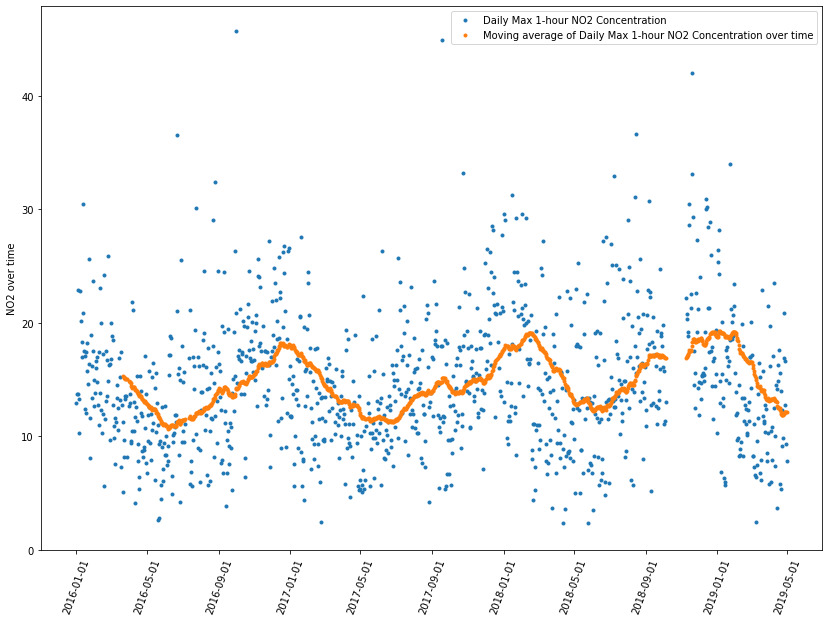

(1147,)

In [23]:
time_var_plot(59,'NO2')

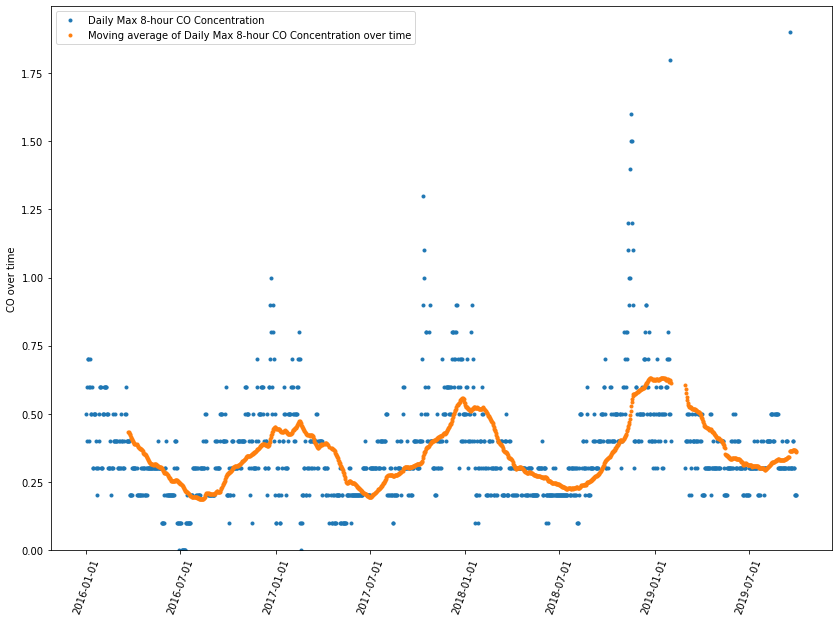

(1321,)

In [24]:
time_var_plot(59,'CO')

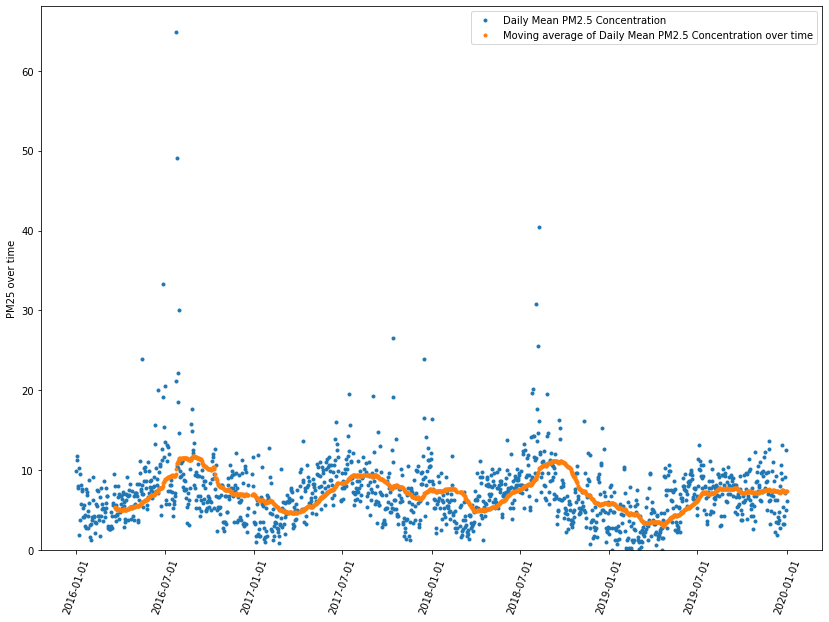

(1436,)

In [25]:
time_var_plot(59,'PM25')

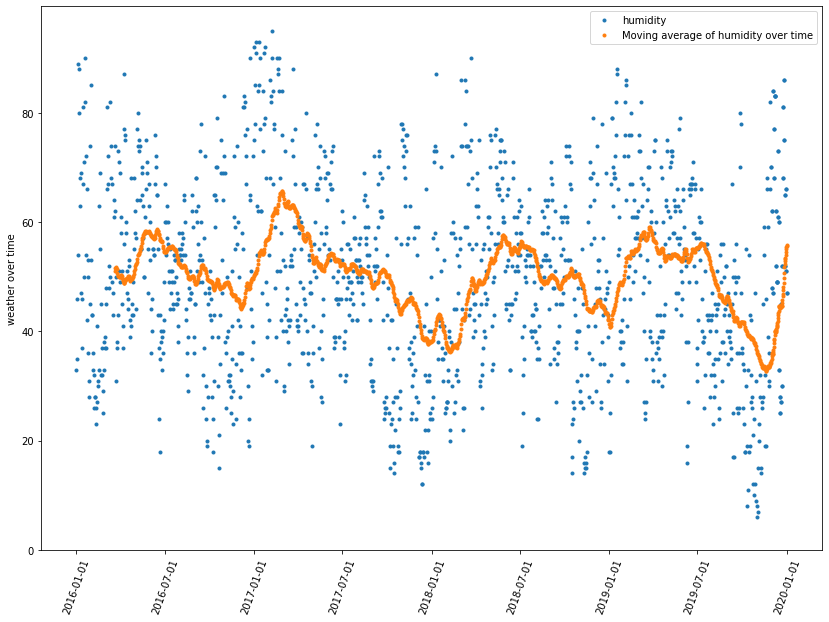

(1492,)

In [26]:
time_var_plot(59,'weather', 'humidity')

## Calculating minimum distance between the measurement locations of data sets.  

On small scales (in this case the size of California) longitude lines are approximately parallel so we can treat longitude and latitude as a Euclidian (flat) space grid on which to calculate distance between the prediction pollutant and weather/pollutant measurement locations. 

In [0]:
def distance(data1, data2):
  loc1 = data1.groupby(by=['lat', 'long']).size().index.to_numpy()
  loc2 = data2.groupby(by=['lat', 'long']).size().index.to_numpy() 
  distances_df = pd.DataFrame(columns=['distance', 'data1 lat',  'data1 long', 'data2 lat', 'data2 long'])
  for i in range(loc1.shape[0]):
    ith_dist = {}
    for j in range(loc2.shape[0]):
      dist = np.sqrt((loc1[i][0]-loc2[j][0])**2 + (loc1[i][1]-loc2[j][1])**2)
      ith_dist.update({j:dist})
    ith_dist = pd.Series(ith_dist)
    min_dist = ith_dist.min()
    min_j = ith_dist.idxmin()
    distances_df.loc[i] =  min_dist, loc1[i][0],loc1[i][1], loc2[min_j][0], loc2[min_j][1]
  return distances_df


Choosing $NO_2$ as the pollutant to predict, it is necessary to calculate the distance between $NO_2$ measurement locations and each of the other data set measurement locations. We will then identify the closest $CO$, $PM25$ and weather measurements to each $NO_2$ location. 



In [0]:
distance_no2_wea = distance(NO2_datai2, weather_datai2)
distance_no2_pm25 = distance(NO2_datai2, PM25_datai2)
distance_no2_co = distance(NO2_datai2, CO_datai2)

To easily merge $NO_2$ data at each location with the corresponding closest data from the other data sets I set the distance data frames indices to be the latitude and longitude for each $NO_2$ location.

In [0]:
distno2wea_index = distance_no2_wea.loc[:, ['data2 lat', 'data2 long']]
df_indexweano2 = pd.MultiIndex.from_frame(distno2wea_index, names=['lat', 'long'])
distance_no2_wea_i= distance_no2_wea.set_index(df_indexweano2)

In [0]:
distno2co_index = distance_no2_co.loc[:, ['data2 lat', 'data2 long']]
df_indexcono2 = pd.MultiIndex.from_frame(distno2co_index, names=['lat', 'long'])
distance_no2_co_i= distance_no2_co.set_index(df_indexcono2)

In [0]:
distno2pm25_index = distance_no2_pm25.loc[:, ['data2 lat', 'data2 long']]
df_indexpm25no2 = pd.MultiIndex.from_frame(distno2pm25_index, names=['lat', 'long'])
distance_no2_pm25_i= distance_no2_pm25.set_index(df_indexpm25no2)


## Relative Uncertainty of measurements from distance.

Here I calculate the relative uncertainty based on distance for the pollutant data sets. In other words, for each day, I find the fractional difference between measurements at two locations to determine how inaccurate a measurement at a certain distance is. 
$$u_r =  \frac{m_{loc_1} - m_{loc_2}}{m_{loc_1}}$$

This will allow me to set a distance cutoff within which identifying $CO$ and $PM25$ measurements to their corresponding nearest $NO_2$ measurement location will be under a certain uncertainty. 

How to determine the distance cutoff:
1. Choose a relative uncertainty. This is usually done with the knowledge of the noise of the measurement. Not knowing the systematics or details of the measuring devices in this case however, I choose a 1% relative uncertainty. 
2. Bin distance and uncertainty for each pollutant, and calculate the percentage of points per distance bin that are within the chosen uncertainty. 
2. Choose percentage of points per binned distance that are within the chosen uncertainty and see what distance this corresponds to.

Note, the choice of distance bin width also changes the outcome of this calculation, and here again better knowledge of noise and systematics of the data could inform what bin width is best. 

In [0]:
def relative_uncertanty(data):
  data=data.sort_index()
  relative_uncertanty_distance = pd.DataFrame(columns=['Rel_Unc', 'dist'])
  index_data = data.index.unique()

  for n, indi in enumerate(index_data):
    for indj in index_data[n:]:
     
      x1 = indi[0]
      x2 = indj[0]
      y1 = indi[1]
      y2 = indj[1]
 
      distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
      if distance<1.0:
        dat1 = data.loc[indi]
        vals1 = dat1.set_index(['date_time'], drop=True)
  
        dat2 = data.loc[indj]
        vals2 = dat2.set_index(['date_time'], drop=True)
      
        rel_unc1 = (vals1-vals2)/(vals1)
        rel_unc2 = (vals2-vals1)/(vals2)
  
        rels = rel_unc1.append(rel_unc2, ignore_index=True)
        rels = rels.rename(columns={rels.columns[0]:'Rel_Unc'}) # np.concatenate([rel_unc1, rel_unc2], axis=0)
        rels['dist'] = distance  
        relative_uncertanty_distance= relative_uncertanty_distance.append(rels)
     
  return relative_uncertanty_distance



In [0]:
relative_uncertanty_NO2 = relative_uncertanty(NO2_datai2.loc[:,['Daily Max 1-hour NO2 Concentration','date_time']]).replace([np.inf, -np.inf], np.nan)

In [0]:
relative_uncertanty_CO = relative_uncertanty(CO_datai2.loc[:,['Daily Max 8-hour CO Concentration','date_time']]).replace([np.inf, -np.inf], np.nan)

In [0]:
relative_uncertanty_PM25 = relative_uncertanty(PM25_datai2.loc[:,['Daily Mean PM2.5 Concentration','date_time']]).replace([np.inf, -np.inf], np.nan)

In [0]:
clean_nan_NO2 = relative_uncertanty_NO2.notna()
cleaned_NO2 = (relative_uncertanty_NO2.loc[clean_nan_NO2.prod(axis=1)==1])
clean_nan_CO = relative_uncertanty_CO.notna()
cleaned_CO = (relative_uncertanty_CO.loc[clean_nan_CO.prod(axis=1)==1])
clean_nan_PM25 = relative_uncertanty_PM25.notna()
cleaned_PM25 = (relative_uncertanty_PM25.loc[clean_nan_PM25.prod(axis=1)==1])

Looking at all distances between $NO_2$ locations and locations of the other data sets, none are larger then 1 (in latitude-longitude) so we only need to consider the relative uncertainty up to this distance. 

Max distance:0.9468738036296054


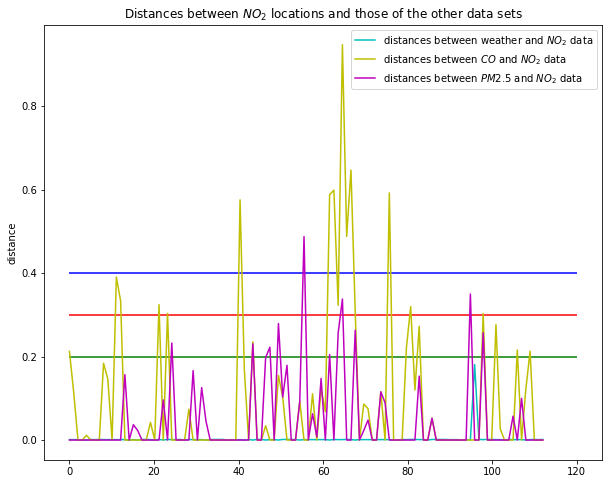

In [38]:
all_dist = np.concatenate([distance_no2_wea_i['distance'].to_numpy(), distance_no2_co_i['distance'].to_numpy(),distance_no2_pm25_i['distance'].to_numpy()])
print(f'Max distance:{all_dist.max()}')
r1 = distance_no2_wea_i['distance'].to_numpy().shape[0]
r2 = distance_no2_co_i['distance'].to_numpy().shape[0]
r3 = distance_no2_pm25_i['distance'].to_numpy().shape[0]
plt.figure(figsize=(10, 8))
plt.title('Distances between $NO_2$ locations and those of the other data sets')
plt.plot(np.linspace(0, r1, r1), distance_no2_wea_i['distance'].to_numpy(), 'c', label='distances between weather and $NO_2$ data')
plt.plot(np.linspace(0, r2, r2), distance_no2_co_i['distance'].to_numpy(), 'y',  label='distances between $CO$ and $NO_2$ data')
plt.plot(np.linspace(0, r3, r3), distance_no2_pm25_i['distance'].to_numpy(), 'm',  label='distances between $PM2.5$ and $NO_2$ data')
plt.ylabel('distance')
plt.hlines(0.2,0, 120, 'g')
plt.hlines(0.3,0, 120, 'r')
plt.hlines(0.4,0, 120, 'b')
plt.legend()
plt.show()


In [0]:
def persentage_cut(cleaned_data, y_bin, plot=True):
  histval, hist_x, hist_y = np.histogram2d(cleaned_data["dist"],cleaned_data["Rel_Unc"],bins=[20,y_bin])
  hist_y = (hist_y[1:]+hist_y[:-1])/2.0
  histvaltotal = np.sum(histval, axis=1)

  goodness = (hist_y<1) & (hist_y>-1)

  sum_uncert = np.apply_along_axis(lambda x: x[goodness], 1, histval)
  sum_dist = np.sum(sum_uncert, axis=1)

  persentage_cut = sum_dist/histvaltotal     
  cuttoff_90index =len(persentage_cut[persentage_cut>0.9])

  cuttoff_90 = hist_x[cuttoff_90index]

  cuttoff_95index =len(persentage_cut[persentage_cut>0.95])

  cuttoff_95 = hist_x[cuttoff_95index]

  if plot==True:
    plt.figure(figsize=(10, 8))
    plt.plot(np.linspace(0,1, num=20), persentage_cut, label='Persentange of points within 1% uncertanty')
    plt.vlines(cuttoff_90, 0.82, 1, 'r', label='Cutoff at 90% of points in bin within 1% uncertanty')
    plt.vlines(cuttoff_95, 0.82, 1, 'm', label='Cutoff at 95% of points in bin within 1% uncertanty')
    plt.xlabel('distance')
    plt.legend()
    plt.show()
  return cuttoff_90, cuttoff_95

<Figure size 720x576 with 0 Axes>

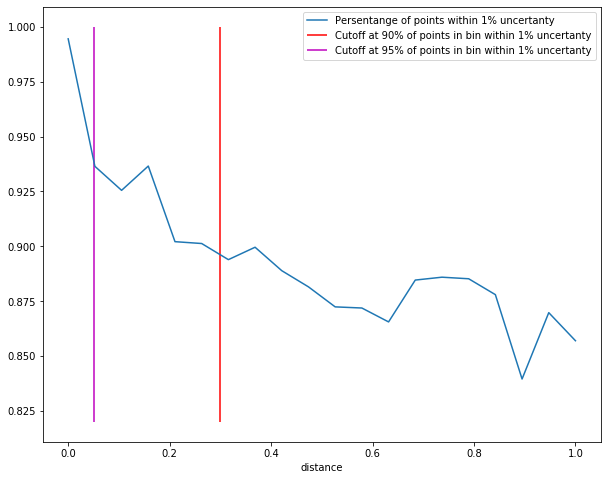

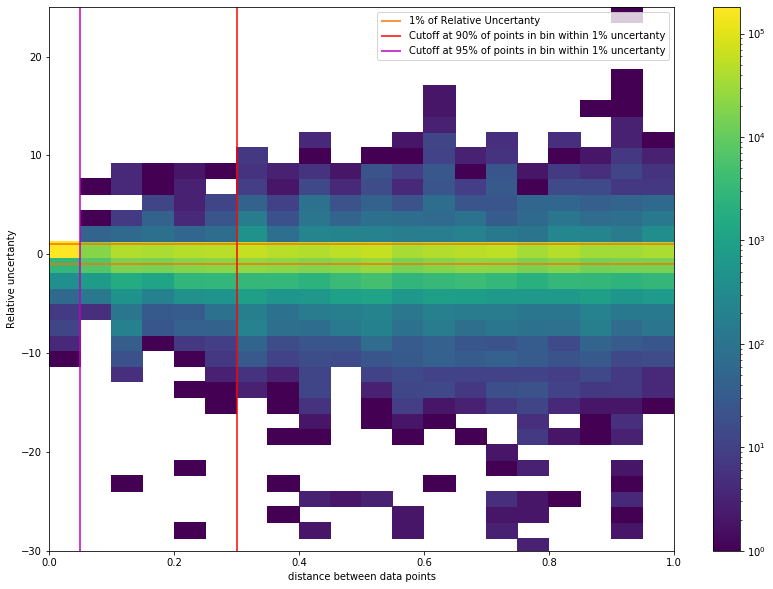

In [40]:
plt.figure(figsize=(10, 8))

cuttoff_90, cuttoff_95= persentage_cut(cleaned_CO, 500)

plt.hist2d(cleaned_CO["dist"],cleaned_CO["Rel_Unc"],bins=(20,50),norm=LogNorm())

plt.hlines(-1,0,cleaned_CO["dist"].shape[0], '#f97306', label='1% of Relative Uncertanty')
plt.hlines(1,0,cleaned_CO["dist"].shape[0], '#f97306')
plt.vlines(cuttoff_90, -50,25, 'r', label='Cutoff at 90% of points in bin within 1% uncertanty')
plt.vlines(cuttoff_95, -50,25, 'm', label='Cutoff at 95% of points in bin within 1% uncertanty')

plt.xlim((0,1))
plt.ylim((-30,25))
plt.legend(loc='best')
plt.xlabel('distance between data points')
plt.ylabel('Relative uncertanty')
plt.colorbar()

plt.show()

<Figure size 1080x720 with 0 Axes>

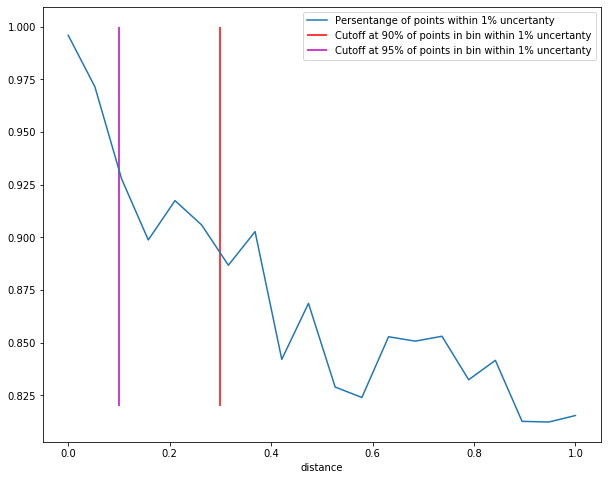

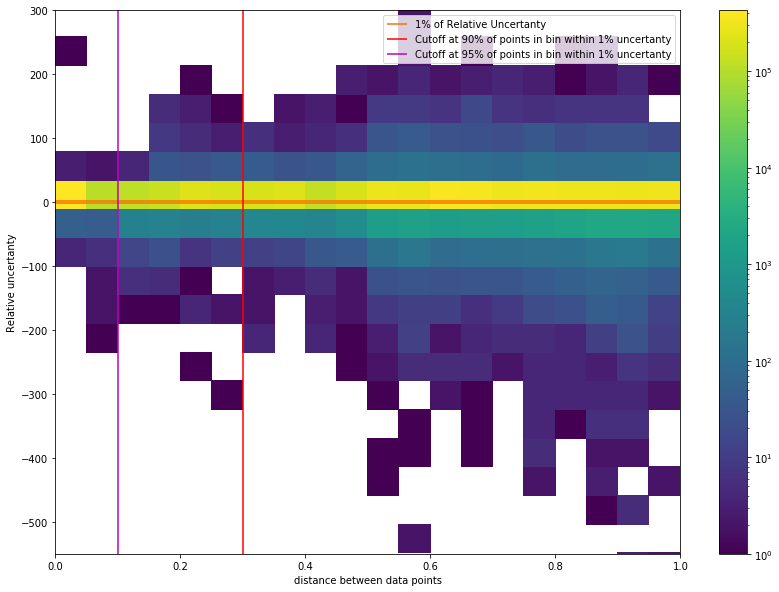

In [41]:
plt.figure(figsize=(15, 10))

cuttoff_90, cuttoff_95= persentage_cut(cleaned_PM25, 5000)

plt.hist2d(cleaned_PM25["dist"],cleaned_PM25["Rel_Unc"],bins=(20,50),norm=LogNorm())

plt.hlines(-1,0,cleaned_PM25["dist"].shape[0], '#f97306', label='1% of Relative Uncertanty')
plt.hlines(1,0,cleaned_PM25["dist"].shape[0], '#f97306')
plt.vlines(cuttoff_90, -550,300, 'r', label='Cutoff at 90% of points in bin within 1% uncertanty')
plt.vlines(cuttoff_95, -550,300, 'm', label='Cutoff at 95% of points in bin within 1% uncertanty')
plt.ylim(-550,300)
plt.xlim((0,1))
plt.legend(loc='best')
plt.xlabel('distance between data points')
plt.ylabel('Relative uncertanty')
plt.colorbar()

plt.show()

The number of bins for uncertainty was chosen to approximately get the same bin size for both pollutants.

In [42]:
cuttoff_90pm, cuttoff_95pm= persentage_cut(cleaned_PM25, 5000, False)  
cuttoff_90co, cuttoff_95co= persentage_cut(cleaned_CO, 500, False)
print(f'90% cutoff CO:{cuttoff_90co}')
print(f'95% cutoff CO:{cuttoff_95co}')
print(f'90% cutoff PM2.5:{cuttoff_90pm}')
print(f'95% cutoff PM2.5:{cuttoff_95pm}')

90% cutoff CO:0.2998242985483311
95% cutoff CO:0.049970716424721846
90% cutoff PM2.5:0.29981784469907763
95% cutoff PM2.5:0.09993928156635921


**Distance Cutoff**

We can see what percentage of the data sets get discarded by keeping data points that are within the cutoff distance. Note that since all weather data was gathered to match pollutant location data none of the points will exceed the 90% distance cutoff, and less then 1% will exceed the 95% distance cutoff. 

In [0]:
distance_no2_wea_cut90 = distance_no2_wea_i[distance_no2_wea_i['distance']<cuttoff_90co]
distance_no2_co_cut90 = distance_no2_co_i[distance_no2_co_i['distance']<cuttoff_90co]
distance_no2_pm25_cut90 = distance_no2_pm25_i[distance_no2_pm25_i['distance']<cuttoff_90pm]

distance_no2_wea_cut95 = distance_no2_wea_i[distance_no2_wea_i['distance']<cuttoff_95co]
distance_no2_co_cut95 = distance_no2_co_i[distance_no2_co_i['distance']<cuttoff_95co]
distance_no2_pm25_cut95 = distance_no2_pm25_i[distance_no2_pm25_i['distance']<cuttoff_95pm]

In [44]:
print(f'{(100*(distance_no2_wea_i.shape[0]-distance_no2_wea_cut90.shape[0])/distance_no2_wea_i.shape[0])}% of NO2 weather data distances is over 90% threashold')
print(f'{(100*(distance_no2_co_i.shape[0]-distance_no2_co_cut90.shape[0])/distance_no2_co_i.shape[0])}% of NO2 CO data distances is over 90% threashold')
print(f'{(100*(distance_no2_pm25_i.shape[0]-distance_no2_pm25_cut90.shape[0])/distance_no2_pm25_i.shape[0])}% of NO2 PM25 data distances is over 90% threashold')

print(f'{(100*(distance_no2_wea_i.shape[0]-distance_no2_wea_cut95.shape[0])/distance_no2_wea_i.shape[0])}% of NO2 weather data distances is over 95% threashold')
print(f'{(100*(distance_no2_co_i.shape[0]-distance_no2_co_cut95.shape[0])/distance_no2_co_i.shape[0])}% of NO2 CO data distances is over 95% threashold')
print(f'{(100*(distance_no2_pm25_i.shape[0]-distance_no2_pm25_cut95.shape[0])/distance_no2_pm25_i.shape[0])}% of NO2 PM25 data distances is over 95% threashold')

0.0% of NO2 weather data distances is over 90% threashold
13.392857142857142% of NO2 CO data distances is over 90% threashold
2.6785714285714284% of NO2 PM25 data distances is over 90% threashold
0.8928571428571429% of NO2 weather data distances is over 95% threashold
34.82142857142857% of NO2 CO data distances is over 95% threashold
17.857142857142858% of NO2 PM25 data distances is over 95% threashold


Since the 95% cutoff discards a significantly larger portion of the data then the 90% cutoff I will use the 90% cutoff. 




### Merging data sets

Here the $NO_2$ data points at each time step are matched to their corresponding nearest pollutant and weather data points. 


In [0]:
distance_no2_wea_cut, distance_no2_co_cut, distance_no2_pm25_cut = distance_no2_wea_cut90, distance_no2_co_cut90, distance_no2_pm25_cut90

In [0]:
wea_plus_distance = weather_datai2.merge(distance_no2_wea_cut,on=['lat','long'], suffixes=('_w','_d'))
index_to_no2loc = wea_plus_distance.loc[:, ['date_time','data1 lat', 'data1 long']]
Mindex_to_no2loc = pd.MultiIndex.from_frame(index_to_no2loc, names=['date', 'lat', 'long'])
wea_distance_no2loc = wea_plus_distance.set_index(Mindex_to_no2loc)
drop_extras = ['Unnamed: 0', 'data1 lat', 'data1 long', 'data2 lat', 'data2 long']
wea_distance_no2loc = wea_distance_no2loc.drop(drop_extras, axis=1)



In [0]:
co_plus_distance = CO_datai2.merge(distance_no2_co_cut,on=['lat','long'], suffixes=('_co','_d'))
index_to_no2loc_co = co_plus_distance.loc[:, ['date_time','data1 lat', 'data1 long']]
Mindex_to_no2loc_co = pd.MultiIndex.from_frame(index_to_no2loc_co, names=['date', 'lat', 'long'])
co_distance_no2loc = co_plus_distance.set_index(Mindex_to_no2loc_co)
drop_extras = ['Unnamed: 0', 'data1 lat', 'data1 long', 'data2 lat', 'data2 long']
co_distance_no2loc = co_distance_no2loc.drop(drop_extras, axis=1)

In [0]:
pm25_plus_distance = PM25_datai2.merge(distance_no2_pm25_cut,on=['lat','long'], suffixes=('_pm25','_d'))
index_to_no2loc_pm25 = pm25_plus_distance.loc[:, ['date_time','data1 lat', 'data1 long']]
Mindex_to_no2loc_pm25 = pd.MultiIndex.from_frame(index_to_no2loc_pm25, names=['date', 'lat', 'long'])
pm25_distance_no2loc = pm25_plus_distance.set_index(Mindex_to_no2loc_pm25)
drop_extras = ['Unnamed: 0', 'data1 lat', 'data1 long', 'data2 lat', 'data2 long']
pm25_distance_no2loc = pm25_distance_no2loc.drop(drop_extras, axis=1)

In [0]:
NO2_levels = NO2_datai.loc[:,['Daily Max 1-hour NO2 Concentration', 'SITE_LATITUDE', 'SITE_LONGITUDE']]
merged_no2_wea_tot = NO2_levels.merge(wea_distance_no2loc,on=['date', 'lat','long'], suffixes=('_no2','_w'))


In [0]:
CO_levels = co_distance_no2loc.loc[:,['Daily Max 8-hour CO Concentration', 'SITE_LATITUDE', 'SITE_LONGITUDE', 'distance']]
merged_no2_wea_co_tot = merged_no2_wea_tot.merge(CO_levels,on=['date', 'lat','long'], suffixes=('_no2','_co'))

In [0]:
PM25_levels = pm25_distance_no2loc.loc[:, ['Daily Mean PM2.5 Concentration', 'SITE_LATITUDE', 'SITE_LONGITUDE', 'distance']]
merged_no2_wea_co_pm25 = merged_no2_wea_co_tot.merge(PM25_levels,on=['date', 'lat','long'], suffixes=('_co','_pm25'))

In [52]:
merged_no2_wea_co_pm25.head()

,,,Daily Max 1-hour NO2 Concentration,SITE_LATITUDE_no2,SITE_LONGITUDE_no2,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,latitude,longitude,distance_no2,Daily Max 8-hour CO Concentration,SITE_LATITUDE_co,SITE_LONGITUDE_co,distance_co,Daily Mean PM2.5 Concentration,SITE_LATITUDE,SITE_LONGITUDE,distance
date,lat,long,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,37.743,-122.17,12.7,37.743065,-122.169935,2016-01-01,9,1,0.0,8.7,1,1,50,No moonrise,11:45 AM,07:24 AM,05:00 PM,-3,3,5,3,18,6,56,0.0,1021,9,10,59,11,"37.743,-122.170",37.743,-122.17,0.0,0.3,37.743065,-122.169935,0.0,3.1,37.743065,-122.169935,0.0
2016-01-02,37.743,-122.17,10.9,37.743065,-122.169935,2016-01-02,10,4,0.0,8.7,1,1,43,12:23 AM,12:15 PM,07:24 AM,05:01 PM,0,5,7,5,15,26,60,0.0,1017,10,10,85,9,"37.743,-122.170",37.743,-122.17,0.0,0.3,37.743065,-122.169935,0.0,8.4,37.743065,-122.169935,0.0
2016-01-03,37.743,-122.17,12.9,37.743065,-122.169935,2016-01-03,13,6,0.0,3.7,1,1,36,01:18 AM,12:46 PM,07:25 AM,05:02 PM,3,8,10,8,19,58,64,0.0,1011,13,10,87,11,"37.743,-122.170",37.743,-122.17,0.0,0.3,37.743065,-122.169935,0.0,12.5,37.743065,-122.169935,0.0
2016-01-04,37.743,-122.17,23.1,37.743065,-122.169935,2016-01-04,13,7,0.0,7.0,1,1,28,02:13 AM,01:20 PM,07:25 AM,05:03 PM,5,9,10,9,15,50,71,1.2,1020,13,10,125,9,"37.743,-122.170",37.743,-122.17,0.0,0.4,37.743065,-122.169935,0.0,5.3,37.743065,-122.169935,0.0
2016-01-05,37.743,-122.17,32.2,37.743065,-122.169935,2016-01-05,12,10,0.0,3.7,1,1,21,03:09 AM,01:57 PM,07:25 AM,05:04 PM,9,9,11,9,24,64,87,0.2,1006,12,10,204,14,"37.743,-122.170",37.743,-122.17,0.0,0.5,37.743065,-122.169935,0.0,3.3,37.743065,-122.169935,0.0


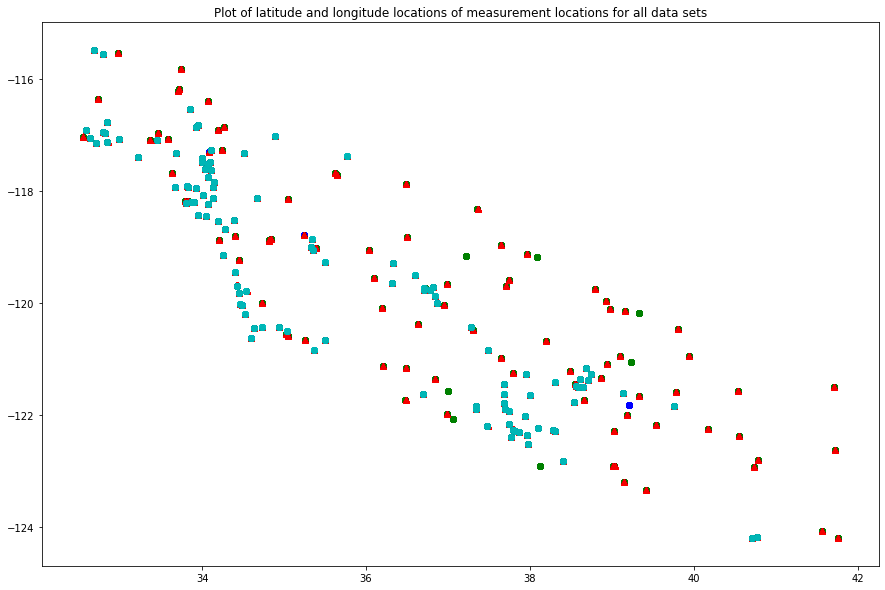

In [53]:
plt.figure(figsize=(15, 10))
plt.title('Plot of latitude and longitude locations of measurement locations for all data sets')

plt.scatter(CO_datai2.index.get_level_values(0).to_numpy(), CO_datai2.index.get_level_values(1).to_numpy(), c='b', alpha=0.1, marker='o')
plt.scatter(PM25_datai2.index.get_level_values(0).to_numpy(), PM25_datai2.index.get_level_values(1).to_numpy(),alpha=0.5, c='g', marker='o')
plt.scatter(weather_datai2.index.get_level_values(0).to_numpy(), weather_datai2.index.get_level_values(1).to_numpy(), c='r',alpha=0.1, marker='^')
plt.scatter(NO2_datai2.index.get_level_values(0).to_numpy(), NO2_datai2.index.get_level_values(1).to_numpy(), c='c',alpha=0.1, marker='o')
plt.show()

Date and locations of merged data set

In [0]:
multi_index = merged_no2_wea_co_pm25.index
index_frame = multi_index.to_frame(index=False)

### Relevant Features
Removing all columns in data sets that are not relevant. 

In [0]:
all_merged_drop_feat =  ['SITE_LATITUDE_no2','SITE_LONGITUDE_no2', 'date_time','totalSnow_cm', 'uvIndex', 'uvIndex.1',
       'moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'location', 'latitude', 'longitude','SITE_LATITUDE_co',
       'SITE_LONGITUDE_co','SITE_LATITUDE', 'SITE_LONGITUDE', 'distance_no2', 'distance','distance_co']

In [0]:
merged_gas_wea_feat = merged_no2_wea_co_pm25.drop(all_merged_drop_feat, axis=1).astype(float) 

### Correlation Matrix

By looking at the correlation matrix between the pollutant and weather features and the $NO_2$ concentrations we can see which features are most correlated, and can be most useful at predicting $NO_2$ levels.


$NO_2$ has the highest correlation with $CO$ concentrations, perhaps indicating a common source for both. Humidity and $PM2.5$ are the next two most important features. 


In [0]:
corr_gas_wea = merged_gas_wea_feat.corr(method="pearson")

(19.5, -0.5)

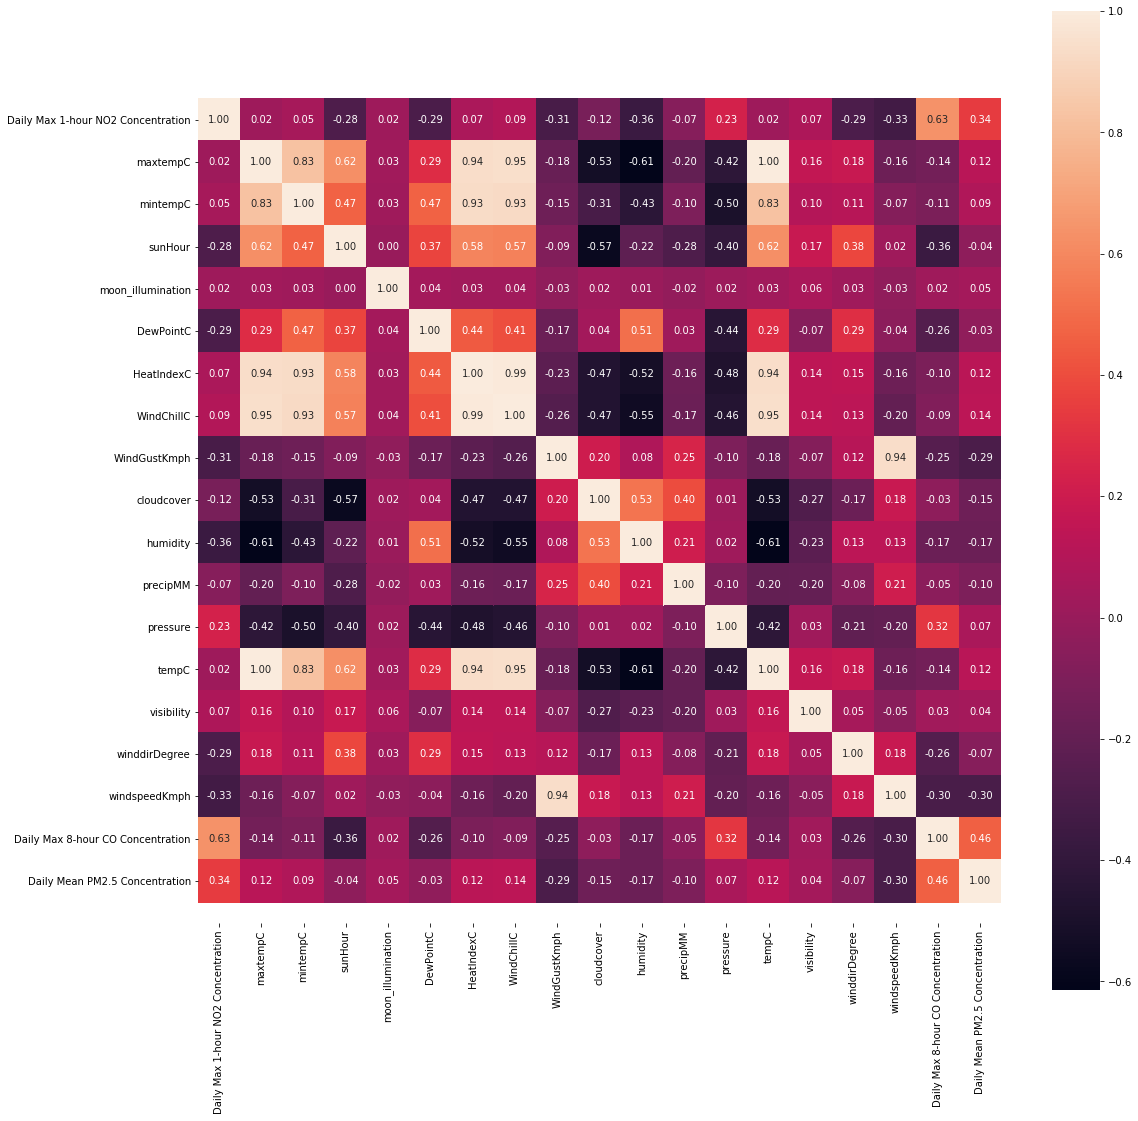

In [58]:
plt.rcParams['figure.figsize']=(18,18)

ax = sns.heatmap(corr_gas_wea, xticklabels=True, yticklabels=True, 
                 annot=True,square=True,fmt='0.2f')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Predicting $NO_2$ levels with weather
In the following section:
1. Rescale data set
2. Subdivide data set into training - cross-validation and test test
3. Train and cross-validate 
     - Linear
     - Polynomial (quadratic)
     - Random Forest Model
4. Compare two cross-validation techniques
     - K-ford cross-validation
     - Group K-fold cross validation
5. Compare performance of models run with subset of most important features.
6. Train model with best set of features and hyper-parameters and make predictions for test data. 





### Rescaling data set
Rescaling data set ensures all features are of the same order of magnitude. 

In [59]:
scaler_tot = StandardScaler(with_std=True)

scaler_tot.fit(merged_gas_wea_feat)

scaled_gaswea = scaler_tot.transform(merged_gas_wea_feat)
feats_gaswea = merged_gas_wea_feat.columns.to_numpy().tolist()
scaled_gas_wea = pd.DataFrame(data = scaled_gaswea, columns = feats_gaswea)  
print(scaled_gas_wea.shape)
scaled_gas_wea['date_time_no2'] = index_frame['date'] 
scaled_gas_wea['latitude_no2'] = index_frame['lat']
scaled_gas_wea['longitude_no2'] = index_frame['long']
scaled_gas_wea.head()

(117331, 19)


,Daily Max 1-hour NO2 Concentration,maxtempC,mintempC,sunHour,moon_illumination,DewPointC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,Daily Max 8-hour CO Concentration,Daily Mean PM2.5 Concentration,date_time_no2,latitude_no2,longitude_no2
0,-0.571140,-1.912754,-2.277397,-0.752347,0.128152,-1.925430,-2.113791,-2.266655,0.781955,-0.594340,-0.088907,-0.177885,1.207490,-1.912754,0.074283,-2.439081,0.544270,-0.488732,-0.806369,2016-01-01,37.743,-122.17
1,-0.700447,-1.774433,-1.700618,-0.752347,-0.095729,-1.397446,-1.793371,-1.958931,0.312398,0.268305,0.123227,-0.177885,0.287661,-1.774433,0.074283,-2.026625,0.044665,-0.488732,-0.252218,2016-01-02,37.743,-122.17
2,-0.556772,-1.359472,-1.316099,-2.431470,-0.319610,-0.869463,-1.312742,-1.497346,0.938473,1.648537,0.335360,-0.177885,-1.092083,-1.359472,0.074283,-1.994898,0.544270,-0.488732,0.176464,2016-01-03,37.743,-122.17
3,0.175969,-1.359472,-1.123840,-1.323249,-0.575475,-0.517473,-1.312742,-1.343484,0.312398,1.303479,0.706593,0.101583,0.977532,-1.359472,0.074283,-1.392078,0.044665,-0.197505,-0.576344,2016-01-04,37.743,-122.17
4,0.829690,-1.497792,-0.547061,-2.431470,-0.799356,0.186505,-1.152532,-1.343484,1.721067,1.907331,1.555127,-0.131307,-2.241869,-1.497792,0.074283,-0.138848,1.293678,0.093722,-0.785457,2016-01-05,37.743,-122.17


### Subdividing data set into training/CV and test sets

Since I am interested in accurately predicting pollutant levels at new locations, the test set will be composed of data from randomly selected locations, rather then taking a random subset of data from each location. 

In [60]:
thirty_percent_data = scaled_gas_wea.shape[0]*0.3
number_unique_loc= scaled_gas_wea['latitude_no2'].unique().shape[0]
number_time_steps_per_loc = scaled_gas_wea.shape[0]/number_unique_loc
number_loc_in_thirty_percent = int(thirty_percent_data/number_time_steps_per_loc)
number_loc_in_thirty_percent

27

In [61]:
unique_loc = NO2_datai2.index.unique().to_numpy()
np.random.shuffle(unique_loc)
test_loc = unique_loc[0:number_loc_in_thirty_percent]
np.asarray(test_loc)

array([(32.792, -115.564), (34.942, -120.436), (34.03, -117.618),
       (32.845, -117.124), (34.1, -117.493), (34.106, -117.275),
       (34.541, -119.792), (37.864, -122.303), (35.331, -119.0),
       (37.682, -121.443), (32.578, -116.922), (37.348, -121.895),
       (34.527, -120.197), (36.597, -119.504), (33.92, -116.859),
       (38.302, -121.421), (37.281, -120.434), (34.144, -117.851),
       (37.338, -121.85), (34.068, -117.526), (37.743, -122.17),
       (32.985, -117.083), (32.789, -116.945), (37.972, -122.521),
       (33.676, -117.331), (34.252, -119.144), (34.445, -119.829)],
      dtype=object)

In [0]:
unique_lat = scaled_gas_wea['latitude_no2'].unique()
np.random.shuffle(unique_lat)
test_lat = unique_lat[0:number_loc_in_thirty_percent].tolist()

In [0]:
scaled_gas_wea_loc = scaled_gas_wea.set_index('latitude_no2')

In [0]:
gaswea_traincv = scaled_gas_wea_loc.drop(test_lat, axis=0)
gaswea_test = scaled_gas_wea_loc.loc[test_lat]

In [0]:
X_wea_gas_test = gaswea_test.drop(['Daily Max 1-hour NO2 Concentration', 'longitude_no2', 'date_time_no2'], axis=1)
Y_wea_gas_test = gaswea_test['Daily Max 1-hour NO2 Concentration']

In [66]:
gaswea_traincv.shape, gaswea_test.shape

((82405, 21), (34926, 21))

In [0]:
X_wea_gasdf = gaswea_traincv.drop(['Daily Max 1-hour NO2 Concentration', 'longitude_no2', 'date_time_no2'], axis=1)
Y_wea_gasdf = gaswea_traincv['Daily Max 1-hour NO2 Concentration']
groups = gaswea_traincv.index.to_numpy()        
n_sp = np.unique(groups).shape[0]

### K-fold Cross Validation

In K-fold CV the training-CV data set is randomly subdivided in a set number of parts and and the algorithm is trained multiple times, each using one of the subsets as the CV data set and the remaining parts as training data. The error metrics for each training/CV permutation are then averaged to give a more robust estimate of the performance of the model. 
Training and cross validating on only one subdivision of the data could give either an overly optimistic or pessimistic metric on how well the model would perform at making predictions for a new set of data. 

In [0]:
def Kfold_cv(Xdf, Ydf, n_sp, model, n_estim=None):
  X = Xdf.to_numpy()
  y = Ydf.to_numpy()
  kf = KFold(n_splits=n_sp)
  mse_avg_cv = []

  for train, test_cv in kf.split(X, y):
    X_train, X_test_cv = X[train], X[test_cv]
    y_train, y_test_cv = y[train], y[test_cv]
    if model == 'RF':
      rf = RandomForestRegressor(n_estimators = n_estim)
      rf.fit(X_train, y_train)
      RF_predictions_cv = rf.predict(X_test_cv)
      mse_cv = metrics.mean_squared_error(y_test_cv, RF_predictions_cv)
      
    if model == 'lin':
      lin = LinearRegression().fit(X_train, y_train)
      y_pred_cv = lin.predict(X_test_cv)
      mse_cv = metrics.mean_squared_error(y_test_cv, y_pred_cv)
  
    if model == 'poly':
      poly = PolynomialFeatures(degree=2)
      X_poly = poly.fit_transform(X_train)
      X_test_poly_cv = poly.fit_transform(X_test_cv)
      lg = LinearRegression()
      lg.fit(X_poly, y_train)
      y_poly_pred_cv= lg.predict(X_test_poly_cv)
      mse_cv = metrics.mean_squared_error(y_test_cv, y_poly_pred_cv)
    mse_avg_cv.append(mse_cv)
  Avg_mse_cv = np.asarray(mse_avg_cv).mean()
  return Avg_mse_cv

In [0]:
kfold_lin_numb_Avg_mse = [Kfold_cv(X_wea_gasdf,Y_wea_gasdf, n,'lin') for n in [10,20,40,n_sp,100]]

In [0]:
kfold_poly_numb_Avg_mse = [Kfold_cv(X_wea_gasdf,Y_wea_gasdf, n,'poly') for n in [10,20,40,n_sp,100]]

In [72]:
kfold_rf_numb_Avg_mse_n10 = Kfold_cv(X_wea_gasdf,Y_wea_gasdf, 10,'RF', 50)
kfold_rf_numb_Avg_mse_n10

0.344666571411017

In [73]:
kfold_rf_numb_Avg_mse_nsp = Kfold_cv(X_wea_gasdf,Y_wea_gasdf, n_sp,'RF', 50)
kfold_rf_numb_Avg_mse_nsp

0.33616415107812864

In [74]:
kfold_rf_numb_Avg_mse_n40 = Kfold_cv(X_wea_gasdf,Y_wea_gasdf, 40,'RF', 50)
kfold_rf_numb_Avg_mse_n40

0.3381310922894621

In [0]:
kfold_rf_numb_Avg_mse=[kfold_rf_numb_Avg_mse_n10, kfold_rf_numb_Avg_mse_n40, kfold_rf_numb_Avg_mse_nsp ]

In [0]:
 #np.save('kfold_rf_Avg_mse.npy',kfold_rf_numb_Avg_mse)
#!cp kfold_rf_Avg_mse.npy "gdrive/My Drive/Colab Notebooks/"

### Group K-fold CV

Group K-fold CV follows the same principle as random K-fold CV, with the only difference being that instead of the data sets being selected randomly, the data is subdivided based on some particular feature of the data. In this case I used location as the feature to subdivide by, but it could be time, or based on any other important feature that characterizes the data. The advantage of subdividing in this way is because there might be some unknown correlation between data points that belong to a particular subgroup, such as data points taken at one location. Not taking this into account, and subdividing the dataset randomly (K-fold CV) might lead to an overly optimistic view of the model's predictive performance. In this case, especially because there are few locations with many data points, random K-fold CV is effectively ignoring the spacial autocorrelation between the data points, which means when making predictions on new locations the estimated errors might be lower then they should be. 

In [76]:
groups.shape, X_wea_gasdf.to_numpy().shape, n_sp

((82405,), (82405, 18), 64)

In [0]:
def group_cv(Xdf, Ydf, n_sp, groups, model, n_estim=None):
  X = Xdf.to_numpy()
  y = Ydf.to_numpy()
  gkf = GroupKFold(n_splits=n_sp)
  mse_avg_cv = []

  for train, test_cv in gkf.split(X, y, groups=groups):
    X_train, X_test_cv = X[train], X[test_cv]
    y_train, y_test_cv = y[train], y[test_cv]
    if model == 'RF':
      rf = RandomForestRegressor(n_estimators = n_estim)
      rf.fit(X_train, y_train)
      RF_predictions_cv = rf.predict(X_test_cv)
      mse_cv = metrics.mean_squared_error(y_test_cv, RF_predictions_cv)
 
    if model == 'lin':
      lin = LinearRegression().fit(X_train, y_train)
      y_pred_cv = lin.predict(X_test_cv)
      mse_cv = metrics.mean_squared_error(y_test_cv, y_pred_cv)

    if model == 'poly':
      poly = PolynomialFeatures(degree=2)
      X_poly = poly.fit_transform(X_train)
      X_test_poly_cv = poly.fit_transform(X_test_cv)
      lg = LinearRegression()
      lg.fit(X_poly, y_train)
      y_poly_pred_cv= lg.predict(X_test_poly_cv)
      mse_cv = metrics.mean_squared_error(y_test_cv, y_poly_pred_cv)
    mse_avg_cv.append(mse_cv)

  Avg_mse_cv = np.asarray(mse_avg_cv).mean()
  return Avg_mse_cv

In [0]:
group_cv_lin = group_cv(X_wea_gasdf,Y_wea_gasdf, n_sp, groups,'lin')

In [0]:
group_cv_poly = group_cv(X_wea_gasdf,Y_wea_gasdf, n_sp, groups,'poly')

In [0]:
group_cv_RF = group_cv(X_wea_gasdf,Y_wea_gasdf, n_sp, groups,'RF',50)

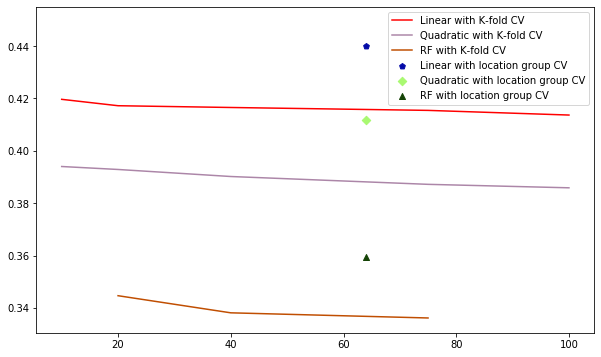

In [83]:
plt.figure(figsize=(10, 6))

plt.scatter(n_sp, group_cv_lin, c='#030aa7', marker='p', label='Linear with location group CV')
plt.scatter(n_sp, group_cv_poly,c='#a9f971',marker='D', label='Quadratic with location group CV')
plt.scatter(n_sp, group_cv_RF,c='#154406',marker='^', label='RF with location group CV')
plt.plot([10,20,40,75,100], kfold_lin_numb_Avg_mse, color ='r',label='Linear with K-fold CV')
plt.plot([10,20,40,75,100], kfold_poly_numb_Avg_mse, color='#ac86a8', label='Quadratic with K-fold CV')
plt.plot([20,40,75], kfold_rf_numb_Avg_mse, color='#c04e01', label='RF with K-fold CV')

plt.legend(loc='best')
plt.show()

As expected for all three models the group K-fold MSE is larger then the K-fold MSE and RF performs the best out of all the models. 

### Feature Selection

Here I look at the importance of each feature in predicting $NO_2# levels and then train a RF model with the features that have more then 95% and 98% of importance (correlation) to see it if improves predictions. 

In [0]:
rf = RandomForestRegressor(n_estimators = 50)
feature_list = X_wea_gasdf.columns
rf.fit(X_wea_gasdf, Y_wea_gasdf)
importances = rf.feature_importances_

In [0]:
feature_importances = pd.DataFrame(importances, index=feature_list.to_numpy(), columns=['Importance']).sort_values(by=['Importance'],ascending=False)

Binned importance for each feature. As was seen in the correlation matrix $CO$ is by far the most important feature. 

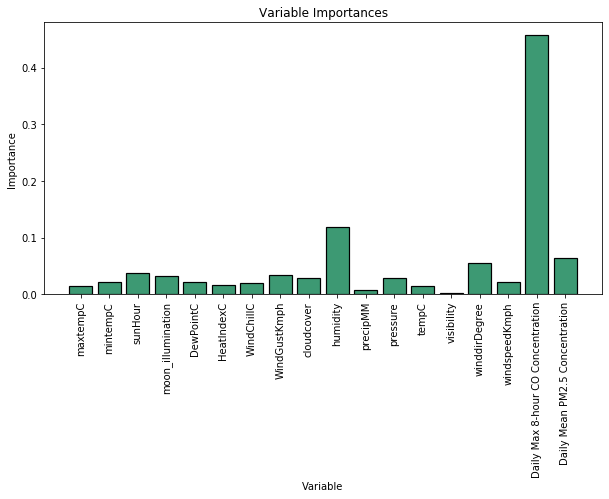

In [88]:
num_features = list(range(len(importances)))
plt.figure(figsize=(10, 5))
plt.bar(num_features, importances, orientation = 'vertical', color = '#3d9973', edgecolor = 'k', linewidth = 1.2)

plt.xticks(num_features, feature_list, rotation='vertical')

plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Taking the cumulative sum of the importances I find the features that make up the 95% and 98% of the total importance.  

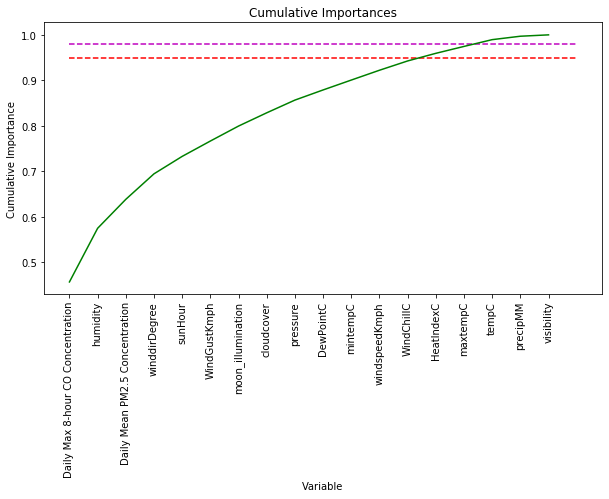

In [89]:
sorted_importances = feature_importances['Importance'].to_numpy() 
sorted_features = feature_importances.index.to_numpy() 

cumulative_importances = np.cumsum(sorted_importances)
plt.figure(figsize=(10, 5))
plt.plot(num_features, cumulative_importances, 'g-')
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
plt.hlines(y = 0.98, xmin=0, xmax=len(sorted_importances), color = 'm', linestyles = 'dashed')
plt.xticks(num_features, sorted_features, rotation = 'vertical')
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [0]:
feature_importances['Cumulative Import'] = cumulative_importances

In [91]:
feature_importances

,Importance,Cumulative Import
Daily Max 8-hour CO Concentration,0.456891,0.456891
humidity,0.117941,0.574832
Daily Mean PM2.5 Concentration,0.063635,0.638467
winddirDegree,0.056070,0.694537
sunHour,0.038337,0.732873
WindGustKmph,0.033719,0.766593
moon_illumination,0.032934,0.799527
cloudcover,0.029113,0.828640
pressure,0.027946,0.856586
DewPointC,0.022307,0.878893


### Test reduced feature sets

Next I train and cross validate the RF model with group K-fold CV to see if there are any imporvements in performace by reducing the features to only the 95% and  98% most important ones. 

In [0]:
features_95import = feature_importances[feature_importances['Cumulative Import']<0.95].index.to_numpy()
features_98import = feature_importances[feature_importances['Cumulative Import']<0.98].index.to_numpy()

In [0]:
group_cv_RF_red95 = group_cv(X_wea_gasdf[features_95import], Y_wea_gasdf, n_sp, groups,'RF',50)

In [0]:
group_cv_RF_red98 = group_cv(X_wea_gasdf[features_98import],Y_wea_gasdf, n_sp, groups,'RF',50)

In [96]:
f'MSE of RF with all features: {n_sp, group_cv_RF}', f'MSE of RF with features with over 98% importance: {group_cv_RF_red98}', f'MSE of RF with features with over 95% importance: {group_cv_RF_red95}'

('MSE of RF with all features: (64, 0.35940608204265145)',
 'MSE of RF with features with over 98% importance: 0.3593021870481806',
 'MSE of RF with features with over 95% importance: 0.3627799008102364')

### Different number of estimators for RF

In [0]:
group_cv_RF_est100 = group_cv(X_wea_gasdf,Y_wea_gasdf, n_sp, groups,'RF',100)

In [98]:
group_cv_RF_est100

0.35590740780197755

In [0]:
group_cv_RF_est10 = group_cv(X_wea_gasdf,Y_wea_gasdf, n_sp, groups,'RF',10)

In [101]:
group_cv_RF_est10

0.38577843827245784

In [103]:
f'RF with 10 n_estimators MSE:{group_cv_RF_est10}',f'RF with 50 n_estimators MSE:{group_cv_RF}',f'RF with 100 n_estimators MSE:{group_cv_RF_est100}'

('RF with 10 n_estimators MSE:0.38577843827245784',
 'RF with 50 n_estimators MSE:0.35940608204265145',
 'RF with 100 n_estimators MSE:0.35590740780197755')

Using only 98% most important features is slightly better then all features. 

## Final Test

Finally I retrain the RF model which proved to give the lowest errors on the data from the test locations: 98% most important features and $N_\text{estimators} = 100$. 

In [0]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_wea_gasdf, Y_wea_gasdf)
RF_predictions = rf.predict(X_wea_gas_test)
mse_test = metrics.mean_squared_error(Y_wea_gas_test, RF_predictions)


In [108]:
mse_test

0.4379373195770764

# Work in progress

### Find featues with lowest errors

In [0]:
def find_lowest_pair(df_metrics):
  lowest_pair = df_metrics['Avg_mse'].idxmin().split(',')
  first_in_pair = lowest_pair[0].split('[')[1][1:-1]
  second_in_pair = lowest_pair[1].split(']')[0][2:-1]
  lowest_mse = df_metrics['Avg_mse'].min()
  return first_in_pair, second_in_pair, lowest_mse

In [0]:
first_in_pair, second_in_pair, lowest_mse = find_lowest_pair(pairmets)

In [0]:
def used_notused_features(X_data):
  features = X_data.columns.to_numpy()
  features_used = [first_in_pair, second_in_pair]
  index_list = []
  for feat in features_used:
    index_n  = np.argwhere(features==feat)
    index_list.append(index_n)
    features_notused= np.delete(features, index_list)
  return features_used, features_notused

In [0]:
features_used , features_notused = used_notused_features(X_wea_gasdf)

In [121]:
features_used

['humidity', 'Daily Max 8-hour CO Concentration']

In [0]:
selected_features = pd.DataFrame(columns=['Avg_mse', 'feature'])

In [0]:

def features_selection(X_data,Y_data,features_notused, features_used, model, cont=False):
  if cont==True:
    df_metrics2 = imported_select_metrics
    begin_feat = df_metrics2.shape[0]
  else:
    begin_feat = 0
    df_metrics2 = pd.DataFrame(columns=['Avg_mae', 'Avg_mse'])
  for feature in features_notused[begin_feat:]:
    print(feature)
    features_set = np.append(features_used, feature)  ### features to be used for each iteration
    Xdf = X_data.loc[:,features_set]
    gcv = group_cv(Xdf, Y_data, n_sp, groups, model)
    Avg_mae, Avg_mse = gcv[0], gcv[1]
    df_metrics2.loc[f'{feature}'] = Avg_mae, Avg_mse
    df_metrics2.to_csv('select_metrics_lin.csv')
    !cp select_metrics_lin.csv "gdrive/My Drive/Colab Notebooks/"
  selected_features.loc[f'{features_used}'] = df_metrics2['Avg_mse'].min(), df_metrics2['Avg_mse'].idxmin()
  selected_features.to_csv('selected_features_lin.csv')
  !cp selected_features_lin.csv "gdrive/My Drive/Colab Notebooks/"
  #pd.concat([df_metrics, df_metrics2])
  return df_metrics2['Avg_mse'].min(), df_metrics2['Avg_mse'].idxmin()

In [0]:
def features_selection_drop(X_data,Y_data, features, model, cont=False):
  if cont==True:
    df_metrics3 = select_metrics
    begin_feat = df_metrics3.shape[0]
  else:
    begin_feat = 0
    df_metrics3 = pd.DataFrame(columns=['Avg_mae', 'Avg_mse'])
  for feature in features[begin_feat:]:
    print(feature)
    Xdf = X_data.drop([feature], axis=1)
    gcv = group_cv(Xdf, Y_data, n_sp, groups, model)
    Avg_mae, Avg_mse = gcv[0], gcv[1]
    df_metrics3.loc[f'{feature}'] = Avg_mae, Avg_mse
    print(Avg_mae, Avg_mse)
    df_metrics3.to_csv('select_metrics2.csv')
    !cp select_metrics2.csv "gdrive/My Drive/Colab Notebooks/"
  return df_metrics3['Avg_mse'].min(), df_metrics3['Avg_mse'].idxmin()

In [0]:
wea_gas_features = X_wea_gasdf.columns

In [0]:

def feature_selection_loop(X_data, Y_data, features_used, features_notused, start_sme, model, Continue):
  features = wea_gas_features
  prev_min = start_sme
  new_min, new_feature = features_selection(X_data,Y_data,features_notused, features_used, model, Continue)

  while new_min<prev_min:
    features_used = np.append(features_used, new_feature)

    index_list = []
    for feat in features_used:
      index_n  = np.argwhere(features==feat)
      index_list.append(index_n)
    features_notused= np.delete(features, index_list)
 
    prev_min = new_min
    new_min, new_feature = features_selection(X_data,Y_data,features_notused, features_used, model, Continue)
    print(new_min, new_feature)
  
  return features_used, new_min


In [0]:
def feature_selection_loop_drop(X_data, Y_data, model, Continue):
  features = wea_gas_features
  new_min, new_feature = features_selection_drop(X_data,Y_data, features, model, Continue)
  features_to_delete =new_feature

  index_list = []
  for feat in features_to_delete:
    index_n  = np.argwhere(features==feat)
    index_list.append(index_n)
  features_to_use= np.delete(features, index_list)
 
  prev_min = new_min
  new_min, new_feature = features_selection_drop(X_data,Y_data, features_to_use, model, Continue)
  print(new_min, new_feature)
   
  while new_min<prev_min:
    features_to_delete = np.append(features_to_delete, new_feature)

    index_list = []
    for feat in features_to_delete:
      index_n  = np.argwhere(features==feat)
      index_list.append(index_n)
    features_to_use= np.delete(features, index_list)
 
    prev_min = new_min
    new_min, new_feature = features_selection_drop(X_data, Y_data, features_to_use, model, Continue)
    print(new_min, new_feature)
  features
  return features_to_use, new_min

In [156]:
feature_drop_lin, feature_drop_lin_mse = feature_selection_loop_drop(X_wea_gasdf, Y_wea_gasdf, 'lin', False)

maxtempC
0.506227515637594 0.43851687474483964
mintempC
0.5090960016200387 0.4433774780595017
sunHour
0.5139549814138856 0.4508797130791875
moon_illumination
0.5062523562127129 0.4385519733073697
DewPointC
0.5058968252010133 0.4380464155559726
HeatIndexC
0.5060366678597321 0.4382502512179799
WindChillC
0.5079782112528787 0.44185153602480476
WindGustKmph
0.5101856096874675 0.4464966882098219
cloudcover
0.5058977201621994 0.4380458035823812
humidity
0.5115708636704117 0.445731106123422
precipMM
0.506320139615845 0.4386319495115607
pressure
0.5062132401964955 0.4385390286967123
tempC
0.5062275156375939 0.43851687474483947
visibility
0.5062375755156158 0.4385584971757943
winddirDegree
0.5072577021022213 0.43883278611437165
windspeedKmph
0.5071144158794824 0.4405458220857981
Daily Max 8-hour CO Concentration
0.5791947769673607 0.559589562213487
Daily Mean PM2.5 Concentration
0.5064709456500395 0.4378822261950288
maxtempC
0.506227515637594 0.43851687474483964
mintempC
0.5090960016200387 0.44

### Time CV

In [0]:

X = X_wea_no2
y = Y_wea_no2
tscv = TimeSeriesSplit(n_splits=5)
mae_avg = []
mse_avg = []
smse_avg = []
for train, test in tscv.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  print(X_train.shape)
  rf.fit(X_train, y_train)
  RF_predictions = rf.predict(X_test)
  mae = metrics.mean_absolute_error(y_test, RF_predictions)
  mse = metrics.mean_squared_error(y_test, RF_predictions)
  smse = metrics.mean_squared_error(y_test, RF_predictions)
  mae_avg.append(mae)
  mse_avg.append(mse)
  smse_avg.append(smse)
Avg_mae = np.asarray(mae_avg).mean()
Avg_mse = np.asarray(mse_avg).mean()
Avg_smse = np.asarray(smse_avg).mean()

(20246, 16)
(20246, 16)
(20246, 16)
(20246, 16)
(20246, 16)
